## Link Prediction
**Link Prediction** (предсказание связей) - это задача в области графовых знаний, направленная на предсказание отношений (рёбер) между сущностями в графовой структуре. В контексте баз данных знаний, где информация представлена в виде графа, задача link prediction становится важным инструментом для дополнения или обновления существующей сети отношений.

Задача link prediction заключается в предсказании отсутствующих рёбер между сущностями, основываясь на известных связях в графе.

Применения link prediction включают:

> Предсказание новых связей между пользователями или группами.

> Предсказание взаимодействий между белками в биологических сетях.

> Предсказание связей между пользователями и товарами.

> Пополнение базы знаний новыми фактами.

В контексте машинного обучения и графовых моделей, задача link prediction решается с использованием методов, таких как графовые эмбеддинги, глубокие нейронные сети, и другие алгоритмы, специфичные для графовых данных.

### Установка зависимостей


Устанавливаем необходимые для работы зависимости

In [1]:
!pip install pykeen matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.3/739.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 32.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00
  Created wheel for rexmex: filename=rexmex-0.1.3-py3-none-any.whl size=19952 sha256=6de4fd5b38789d6dc48efc1ee34e7d45a74fb0accfe3140e2823960c867a232a
  Stored in directory: /root/.cache/pip/wheels/13/31/9d/51fb64454e6012bc88dd72b57609646432e478ba35772736d6
Successfully built rexmex


Далее, импортируем необходимых модулей

In [3]:
import pykeen
import torch
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from pykeen.evaluation import ClassificationEvaluator
from pykeen.datasets import CoDExSmall

В этой работе мы снова будем использовать уже известный dataset CoDExSmall

In [4]:
# Загрузка графового датасета CoDExSmall
dataset = CoDExSmall()

Проверяем доступность GPU для вычислений

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Метрики для оценки работы модели

В рамках этой работы мы рассмотрим несколько classification метрик.

#### **ROC-AUC Score (Receiver Operating Characteristic - Площадь под кривой):**

> **ROC-AUC** - это метрика, используемая для оценки производительности бинарной классификационной модели.

> Измеряет площадь под кривой ROC, которая отображает соотношение верно положительных случаев к ложно положительным случаям при различных значениях порога.

> Более высокий показатель ROC-AUC указывает на лучшую дискриминацию между положительными и отрицательными случаями.

#### **Precision:**

> **Precision** - это метрика, оценивающая точность положительных предсказаний классификационной модели.

> Рассчитывается как отношение верно положительных предсказаний к общему числу положительных предсказаний (верно положительные + ложно положительные).

> Precision особенно важна, когда стоимость ложно положительных случаев высока.

#### **Accuracy:**

>  **Accuracy** - простая метрика, измеряющая общую правильность классификационной модели.

> Рассчитывается как отношение правильно предсказанных случаев (верно положительные + верно отрицательные) к общему числу случаев.

> В то время как Accuracy легко интерпретировать, она может быть несостоятельной для несбалансированных наборов данных, где один класс значительно превосходит другой.

#### **F1-мера (F1 Score):**

> **F1-мера** - это гармоническое среднее точности и полноты.

> Обеспечивает баланс между точностью и полнотой, что делает ее подходящей метрикой для несбалансированных наборов данных.

Эти метрики часто используются для оценки моделей, и их выбор зависит от конкретных целей и характеристик решаемой проблемы. Например, в сценариях, где ложно положительные или ложно отрицательные случаи имеют разные стоимости, могут быть более актуальными точность или полнота. ROC-AUC обеспечивает всесторонний обзор способности модели к дискриминации между классами при различных значениях порога.

In [6]:
#Объявим переменные для хранения рассчитанных метрик
roc_auc_score = []
precision = []
accuracy = []
f1 = []

#Переменная для хранения рразличных пайплайнов pykeen
pipeline_results_list = []

 Чтобы ценить работу модели на наборе данных будем использовать ClassificationEvaluator() позволяющий рассчитывать рассмотренные ранее метрики

In [7]:
evaluator = ClassificationEvaluator()

Обучим модель ComplEx для разного количества эпох, для каждой модели рассчитаем и сохраним значения метрик

In [10]:
# Список значений количества эпох
epochs = [1,20,50,100,250]

for epoch in epochs:

  # Обучаем модель
  pipeline_results = pipeline(
      model="ComplEx",
      dataset=dataset,
      training_kwargs=dict(num_epochs=epoch),
      device=device
  )

  # Сохраняем обученную модель
  pipeline_results_list.append(pipeline_results)

  model = pipeline_results.model
  # Рассчитываем метрики для обученной модели и датасета CoDExSmall
  metrics = evaluator.evaluate(model, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

  # Сохраняем рассчитанные метрики
  roc_auc_score.append(metrics.get_metric('roc_auc_score'))
  precision.append(metrics.get_metric('average_precision_score'))
  accuracy.append(metrics.get_metric('accuracy_score'))
  f1.append(metrics.get_metric('f1_score'))

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/1 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 20.45s seconds
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Evaluation took 19.93s seconds
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Evaluation took 20.39s seconds
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.30s seconds
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Evaluation took 19.93s seconds
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/250 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/129 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

/usr/local/lib/python3.10/dist-packages/rexmex/metrics/classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
INFO:pykeen.evaluation.evaluator:Evaluation took 20.36s seconds


После того как метрики рассчитаны для разного количества эпох обучения визуализируем полученные метрики

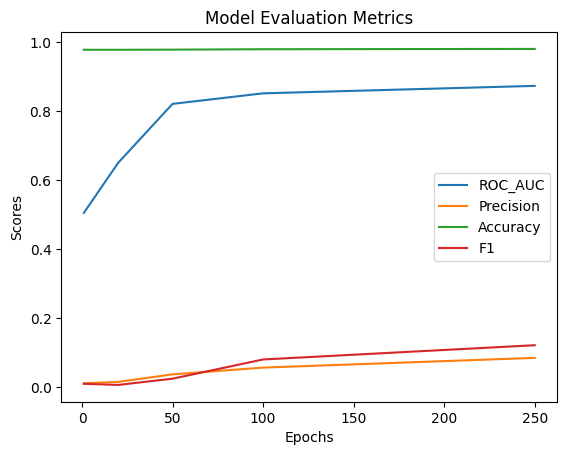

In [11]:
# В качесте лейблов используем список значений эпох
labels = epochs

# Plotting ROC AUC scores
plt.plot(labels, roc_auc_score, label='ROC_AUC')

# Plotting precision scores
plt.plot(labels, precision, label='Precision')

# Plotting accuracy scores
plt.plot(labels, accuracy, label='Accuracy')

# Plotting F1
plt.plot(labels, f1, label='F1')

# Добавляем легенду, лейблы и название
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')

# Отрисовываем график
plt.show()


{'cache_root': PosixPath('/root/.data/pykeen/datasets/codexsmall'),
 'training_url': 'https://raw.githubusercontent.com/tsafavi/codex/master/data/triples//codex-s/train.txt',
 'testing_url': 'https://raw.githubusercontent.com/tsafavi/codex/master/data/triples//codex-s/test.txt',
 'validation_url': 'https://raw.githubusercontent.com/tsafavi/codex/master/data/triples//codex-s/valid.txt',
 'training_path': PosixPath('/root/.data/pykeen/datasets/codexsmall/train.txt'),
 'testing_path': PosixPath('/root/.data/pykeen/datasets/codexsmall/test.txt'),
 'validation_path': PosixPath('/root/.data/pykeen/datasets/codexsmall/valid.txt'),
 '_create_inverse_triples': False,
 'load_triples_kwargs': None,
 '_training': TriplesFactory(num_entities=2034, num_relations=42, create_inverse_triples=False, num_triples=32888, path="/root/.data/pykeen/datasets/codexsmall/train.txt"),
 '_testing': TriplesFactory(num_entities=2034, num_relations=42, create_inverse_triples=False, num_triples=1828, path="/root/.data

Далее рассмотрим  метод predict_target(). Основной вариант использования pykeen.predict.predict_target() — прогнозирование ссылок или прогнозирование отношений. Например, мы можем использовать наши модели для оценки всех возможных tail объектов запроса (uk, conferences, ?).

In [18]:
from pykeen.predict import predict_target
for idx, ep in enumerate(epochs):
  pipeline_result = pipeline_results_list[idx]
  pred = predict_target(
      model=pipeline_result.model,
      head=0,
      relation=1,
      triples_factory=pipeline_result.training,
  )

  pred_filtered = pred.filter_triples(dataset.training)
  pred_annotated = pred_filtered.add_membership_columns(validation=dataset.validation, testing=dataset.testing)
  pred_df = pred_annotated.df[['tail_label','score']]
  print(f'Результат при вычислении {ep} эпох')
  print(pred_df)
  print('__________________________')

Результат при вычислении 1 эпох
     tail_label       score
608     Q194287  114.371857
1353     Q43293   94.102432
961      Q27306   83.321991
441     Q172632   80.919312
1171    Q348497   78.458527
...         ...         ...
1134    Q337234  -77.827393
1872     Q82238  -82.192261
1799     Q77144  -88.607086
1866       Q819  -92.273369
1904    Q842324  -94.868988

[2034 rows x 2 columns]
__________________________
Результат при вычислении 20 эпох
     tail_label       score
1987      Q9391  105.155273
1438     Q47087   91.990768
567     Q190585   82.415161
1505       Q504   73.707664
36      Q104000   71.547462
...         ...         ...
1535       Q538  -79.437073
1127    Q335142  -80.382561
750        Q221  -80.429420
1926      Q8646  -80.614990
1441    Q471443  -95.673874

[2034 rows x 2 columns]
__________________________
Результат при вычислении 50 эпох
     tail_label      score
470     Q180468  97.070183
1623      Q6096  83.704391
836     Q234750  83.303116
278     Q151403  8

В результате выполнения лабораторной работы была успешно обучены модели, способная предсказывать связи между сущностями в графовой структуре.

Проведенный анализ с использованием метрик precision, accuracy, F1 и ROC-AUC позволяет сделать следующие выводы:

**Precision, Accuracy, и F1:**

Метрики precision, accuracy и F1 предоставляют информацию о качестве классификации модели. Высокие значения этих метрик указывают на эффективность модели в правильном предсказании связей.

**ROC-AUC:**

ROC-AUC метрика измеряет способность модели различать между положительными и отрицательными классами при различных порогах. Значение ROC-AUC близкое к 1.0 говорит о высокой дискриминации, что подтверждает успешное обучение модели.


Попробуйте обучыить другую модель. Примените обученную модель к другому датасету. Проанализируйте результаты. Хорошим вариантом будет преднамеренно удалить существующую связку и исследовать работу модели на предсказании удаленной связи.